## Train pointwise ML model using first order gradients, but on wider stencil. Also with local norm.
## Also using the parallel perp division 

Taking inspiration from LES gradient models we train a ML model using the first order gradients of velocity and slopes as input. The output will be the streamfunction. 

Here we attempt to a local normalization, with the hope that this helps improve the model performance. 


$$
\mathbf{\Psi} = \triangle x^2 |\nabla \overline{\mathbf{u}}| |\overline{\mathbf{S}}| g_{nn} (\nabla \overline{\mathbf{u}}/|\nabla \overline{\mathbf{u}}|, \overline{\mathbf{S}}/|\overline{\mathbf{S}}|)
$$


Here the idea is that $g_{nn}$ may learn something that is less reliant on the amplitudes of simulation. Here the magnitudes of the velocity gradients and slopes are local, so calculated over the quantities over the region that the prediction is made. 

A more general form will be of the type:

$$
\mathbf{\Psi} = \triangle x^2 |\nabla \overline{\mathbf{u}}| |\overline{\mathbf{S}}| g_{nn} (\nabla \overline{\mathbf{u}}/|\nabla \overline{\mathbf{u}}|, \overline{\mathbf{S}}/|\overline{\mathbf{S}}|, \triangle x)
$$ 
But then the question becomes if we want to let the nn adjust based on the length scales, or if we think that the g may be scale invariant (or we adjust some coeff in front). 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

2024-03-08 19:51:24.579883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 19:51:24.579916: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 19:51:24.579921: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
kind = 'MITgcm'
MITgcm_bucket ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

window_size=1

#fname = f'{MITgcm_bucket}/ML_data/ds_ML_'+L+'km_3D'
    
# Open dataset
ML_data = datasets.MITgcm_all_transformer('-', '-', 
                                      input_channels=['U_x', 'U_y', 
                                                      'V_x', 'V_y', 
                                                      'Sx', 'Sy'])

In [6]:
ML_data.read_datatree(MITgcm_bucket, keep_filt_scale=True, para_perp_out=True)

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_50km_3D
Centered
Out para perp
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Out para perp
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_200km_3D
Centered
Out para perp
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_400km_3D
Centered
Out para perp


In [7]:
ML_data.generate_test_train_batches(normalize=False)

Test and train batches split. Number of batches: 44-4


In [8]:
ANN_model = ML_classes.ANN(num_in = len(ML_data.input_channels))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
regress_sys = ML_classes.RegressionSystem(ANN_model, local_norm=True)

In [10]:
%%time
regress_sys.train_system(ML_data, 31, 1)

Train loss step 0:  14.906734975901516 test loss: 6.455430388450623
Train loss step 1:  5.372953274033287 test loss: 5.357800006866455
Train loss step 2:  4.708368648182262 test loss: 4.843255996704102
Train loss step 3:  4.3644348274577744 test loss: 4.593209862709045
Train loss step 4:  4.184389862147245 test loss: 4.45799195766449
Train loss step 5:  4.075441631403836 test loss: 4.367826461791992
Train loss step 6:  3.997361486608332 test loss: 4.306921482086182
Train loss step 7:  3.9425810196182947 test loss: 4.263686776161194
Train loss step 8:  3.9025442491878164 test loss: 4.230242967605591
Train loss step 9:  3.8715422316031023 test loss: 4.201201319694519
Train loss step 10:  3.8467519229108635 test loss: 4.174210429191589
Train loss step 11:  3.8254317858002405 test loss: 4.152777075767517
Train loss step 12:  3.808390042998574 test loss: 4.138951659202576
Train loss step 13:  3.795295016332106 test loss: 4.124682903289795
Train loss step 14:  3.7849211638624016 test loss: 4

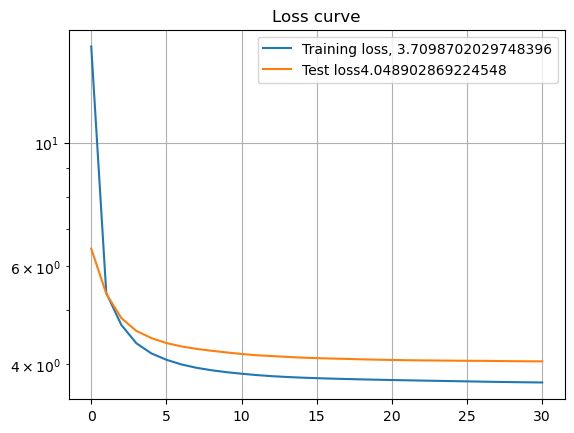

In [12]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.title('Loss curve')
plt.grid()
plt.yscale('log')
plt.legend()

In [13]:
# Save the checkpoint
CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/ckpts_all_MITgcm_window_1_local_norm_true_out_para_perp'
regress_sys.save_checkpoint(CKPT_DIR)

# Save model nc file
model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/' +'MITgcm_all_window_1_local_norm_true_out_para_perp'+'.nc'
regress_sys.save_weights_nc(model_nc)